**In case of problems or questions, please first check the list of [Frequently Asked Questions (FAQ)](https://stardist.net/docs/faq.html).**

Please shutdown all other training/prediction notebooks before running this notebook (as those might occupy the GPU memory otherwise).

In [ ]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist import Rays_GoldenSpiral
from stardist.matching import matching, matching_dataset
from stardist.models import Config3D, StarDist3D, StarDistData3D
from n2v.models import N2VConfig
np.random.seed(42)
lbl_cmap = random_label_cmap()

# Data

We assume that data has already been downloaded via notebook [1_data.ipynb](1_data.ipynb).  

<div class="alert alert-block alert-info">
Training data (for input `X` with associated label masks `Y`) can be provided via lists of numpy arrays, where each image can have a different size. Alternatively, a single numpy array can also be used if all images have the same size.  
Input images can either be three-dimensional (single-channel) or four-dimensional (multi-channel) arrays, where the channel axis comes last. Label images need to be integer-valued.
</div>

In [2]:
X_trn = sorted(glob('/mnt/shared/potatoshapes/shannonsdata/raw_data/3D_data/Lyso_GroundTruth/Raw/*.tif'))
X_val = sorted(glob('/mnt/shared/potatoshapes/shannonsdata/raw_data/3D_data/Lyso_GroundTruth/Raw_test_val/*.tif'))
Y_trn = sorted(glob('/mnt/shared/potatoshapes/shannonsdata/raw_data/3D_data/Lyso_GroundTruth/Annotations/*.tif'))
Y_val = sorted(glob('/mnt/shared/potatoshapes/shannonsdata/raw_data/3D_data/Lyso_GroundTruth/Annotations_test_val/*.tif'))
# assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))

In [ ]:
print(X_trn)

In [3]:
X_trn = list(map(imread,X_trn))
X_val = list(map(imread,X_val))
Y_trn = list(map(imread,Y_trn))
Y_val = list(map(imread,Y_val))
# n_channel = if X_trn[0].ndim == 3 else X_trn[0].shape[-1]
n_channel = 1

In [ ]:
print(len(X_trn))

Normalize images and fill small label holes.

In [4]:
axis_norm = (0,1,2)   # normalize channels independently
# axis_norm = (0,1,2,3) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 3 in axis_norm else 'independently'))
    sys.stdout.flush()

X_trn = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X_trn)]
X_val = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X_val)]
Y_trn = [fill_label_holes(y) for y in tqdm(Y_trn)]
Y_val = [fill_label_holes(y) for y in tqdm(Y_val)]

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.61it/s]


Split into train and validation datasets.

In [ ]:
# assert len(X) > 1, "not enough training data"
# rng = np.random.RandomState(42)
# ind = rng.permutation(len(X))
# n_val = max(1, int(round(0.15 * len(ind))))
# ind_train, ind_val = ind[:-n_val], ind[-n_val:]
# X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
# X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
# print('number of images: %3d' % len(X))
# print('- training:       %3d' % len(X_trn))
# print('- validation:     %3d' % len(X_val))

Training data consists of pairs of input image and label instances.

In [5]:
def plot_img_label(img, lbl, img_title="image (XY slice)", lbl_title="label (XY slice)", z=None, **kwargs):
    if z is None:
        z = img.shape[0] // 2    
    fig, (ai,al) = plt.subplots(1,2, figsize=(12,5), gridspec_kw=dict(width_ratios=(1.25,1)))
    im = ai.imshow(img[z], cmap='gray', clim=(0,1))
    ai.set_title(img_title)    
    fig.colorbar(im, ax=ai)
    al.imshow(lbl[z], cmap=lbl_cmap)
    al.set_title(lbl_title)
    plt.tight_layout()

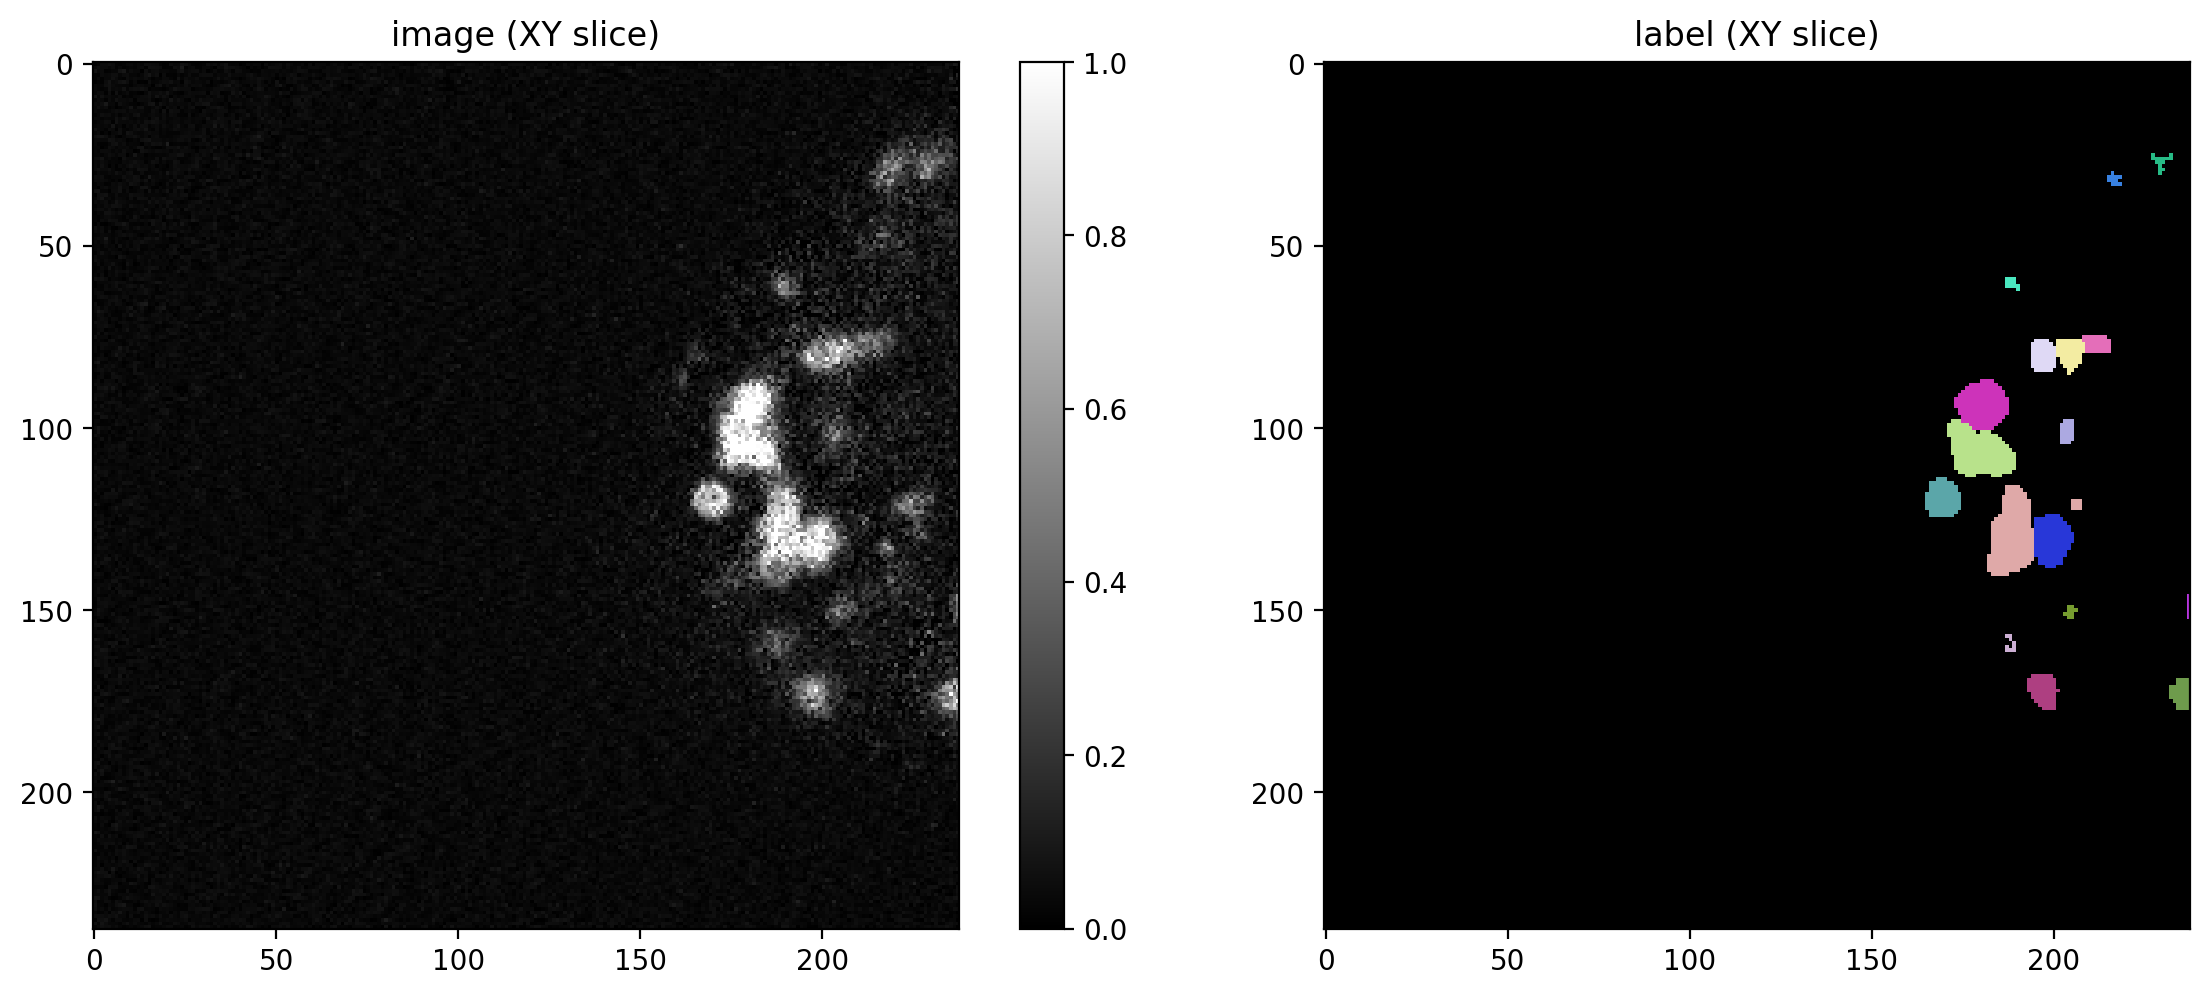

In [6]:
i = 0
img, lbl = X_trn[i], Y_trn[i]
assert img.ndim in (3,4)
img = img if img.ndim==3 else img[...,:3]
plot_img_label(img,lbl)
None;

# Configuration

A `StarDist3D` model is specified via a `Config3D` object.

In [ ]:
# print(Config3D.__doc__)

In [7]:
extents = calculate_extents(Y_trn)
anisotropy = tuple(np.max(extents) / extents)
print('empirical anisotropy of labeled objects = %s' % str(anisotropy))

empirical anisotropy of labeled objects = (3.3333333333333335, 1.0, 1.0256410256410255)


In [8]:
# 96 is a good default choice (see 1_data.ipynb)
n_rays = 96

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = False and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (1,1,1) # tuple(1 if a > 1.5 else 2 for a in anisotropy)

# Use rays on a Fibonacci lattice adjusted for measured anisotropy of the training data
rays = Rays_GoldenSpiral(n_rays, anisotropy=anisotropy)

conf = Config3D( 
    rays             = rays,
    grid             = grid,
    anisotropy       = anisotropy,
    use_gpu          = use_gpu,
    n_channel_in     = n_channel,
    # adjust for your data below (make patch size as large as possible)
    backbone         = 'n2v',
    train_patch_size = (8,48,48),
    train_batch_size = 2,
    train_steps_per_epoch=200,
    n2vmodel_name = 'n2v_model',
    n2vbasedir = '/mnt/shared/potatoshapes/shannonsdata/git_repo/stardist_surgery/examples/3D/'
)

vars(conf)

{'n_dim': 3,
 'axes': 'ZYXC',
 'n_channel_in': 1,
 'n_channel_out': 97,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 96,
 'grid': (1, 1, 1),
 'anisotropy': (3.3333333333333335, 1.0, 1.0256410256410255),
 'backbone': 'n2v',
 'rays_json': {'name': 'Rays_GoldenSpiral',
  'kwargs': {'n': 96,
   'anisotropy': (3.3333333333333335, 1.0, 1.0256410256410255)}},
 'n_classes': None,
 'n2vmodel_name': 'n2v_model',
 'n2vbasedir': '/mnt/shared/potatoshapes/shannonsdata/git_repo/stardist_surgery/examples/3D/',
 'unet_n_depth': 2,
 'unet_kernel_size': (3, 3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, None, 1),
 'net_mask_shape': (None, None, None, 1),
 'train_patch_size': (8, 4

In [9]:
if use_gpu:
    from csbdeep.utils.tf import limit_gpu_memory
    # adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
    limit_gpu_memory(0.8)
    # alternatively, try this:
    # limit_gpu_memory(None, allow_growth=True)

**Note:** The trained `StarDist3D` model will *not* predict completed shapes for partially visible objects at the image boundary.

In [10]:
model = StarDist3D(conf, name='stardist', basedir='models')

base_model.py (148): output path for model already exists, files may be overwritten: /home/rhoadss/Documents/stardist_surgery/examples/3D/models/stardist
2022-09-05 14:49:14.660829: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-09-05 14:49:14.720526: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-05 14:49:14.722122: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.56GiB deviceMemoryBandwidth: 298.08GiB/s
2022-09-05 14:49:14.722195: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-09-05 14:49:14.724483: I tensorflow/stream_executor/platform

Loading network weights from 'weights_best.h5'.
Using default values: prob_thresh=0.5, nms_thresh=0.4.


Check if the neural network has a large enough field of view to see up to the boundary of most objects.

In [ ]:
# median_size = calculate_extents(Y, np.median)
# fov = np.array(model._axes_tile_overlap('ZYX'))
# print(f"median object size:      {median_size}")
# print(f"network field of view :  {fov}")
# if any(median_size > fov):
#     print("WARNING: median object size larger than field of view of the neural network.")

# Data Augmentation

You can define a function/callable that applies augmentation to each batch of the data generator.  
We here use an `augmenter` that applies random rotations, flips, and intensity changes, which are typically sensible for (3D) microscopy images (but you can disable augmentation by setting `augmenter = None`).

In [11]:
def random_fliprot(img, mask, axis=None): 
    if axis is None:
        axis = tuple(range(mask.ndim))
    axis = tuple(axis)
            
    assert img.ndim>=mask.ndim
    perm = tuple(np.random.permutation(axis))
    transpose_axis = np.arange(mask.ndim)
    for a, p in zip(axis, perm):
        transpose_axis[a] = p
    transpose_axis = tuple(transpose_axis)
    img = img.transpose(transpose_axis + tuple(range(mask.ndim, img.ndim))) 
    mask = mask.transpose(transpose_axis) 
    for ax in axis: 
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask 

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2) + np.random.uniform(-0.2,0.2)
    return img

def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    # Note that we only use fliprots along axis=(1,2), i.e. the yx axis 
    # as 3D microscopy acquisitions are usually not axially symmetric
    x, y = random_fliprot(x, y, axis=(1,2))
    x = random_intensity_change(x)
    return x, y


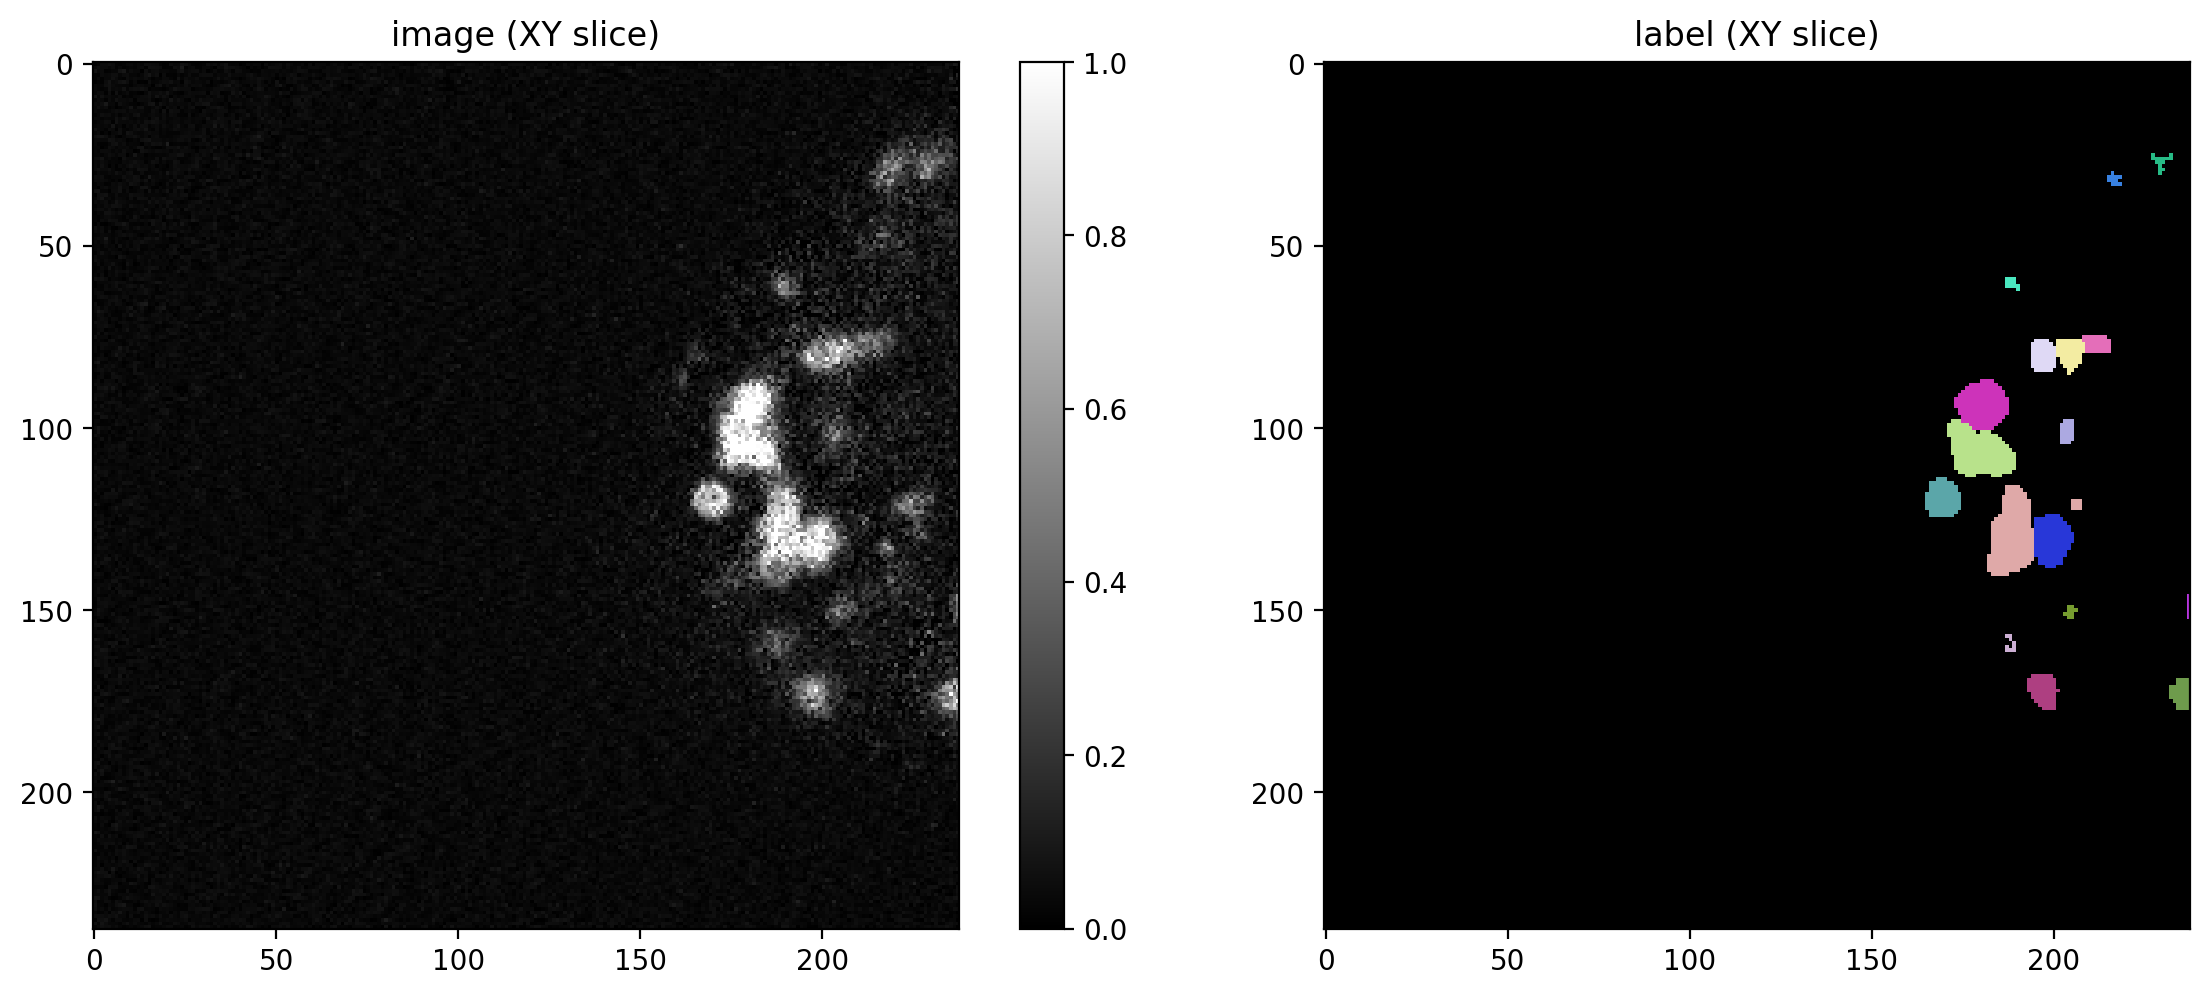

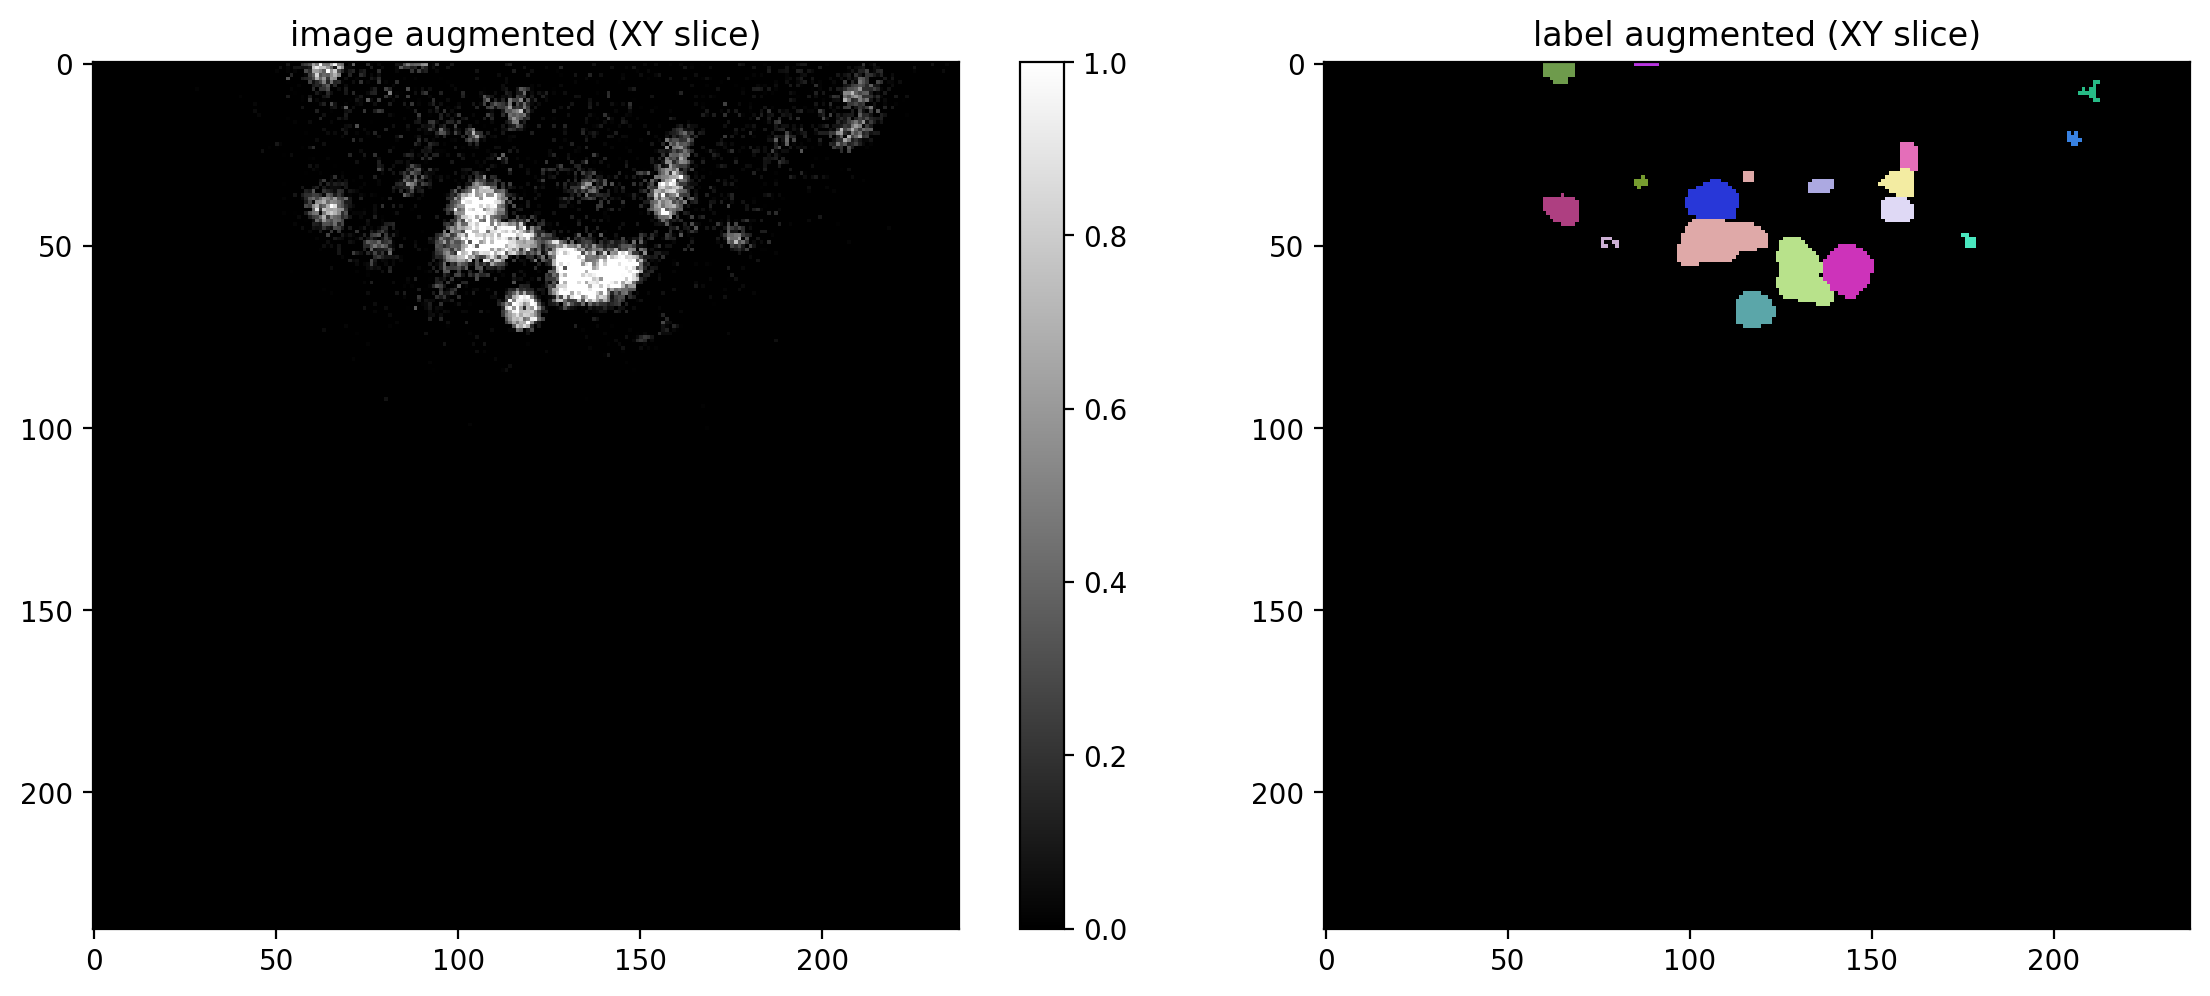

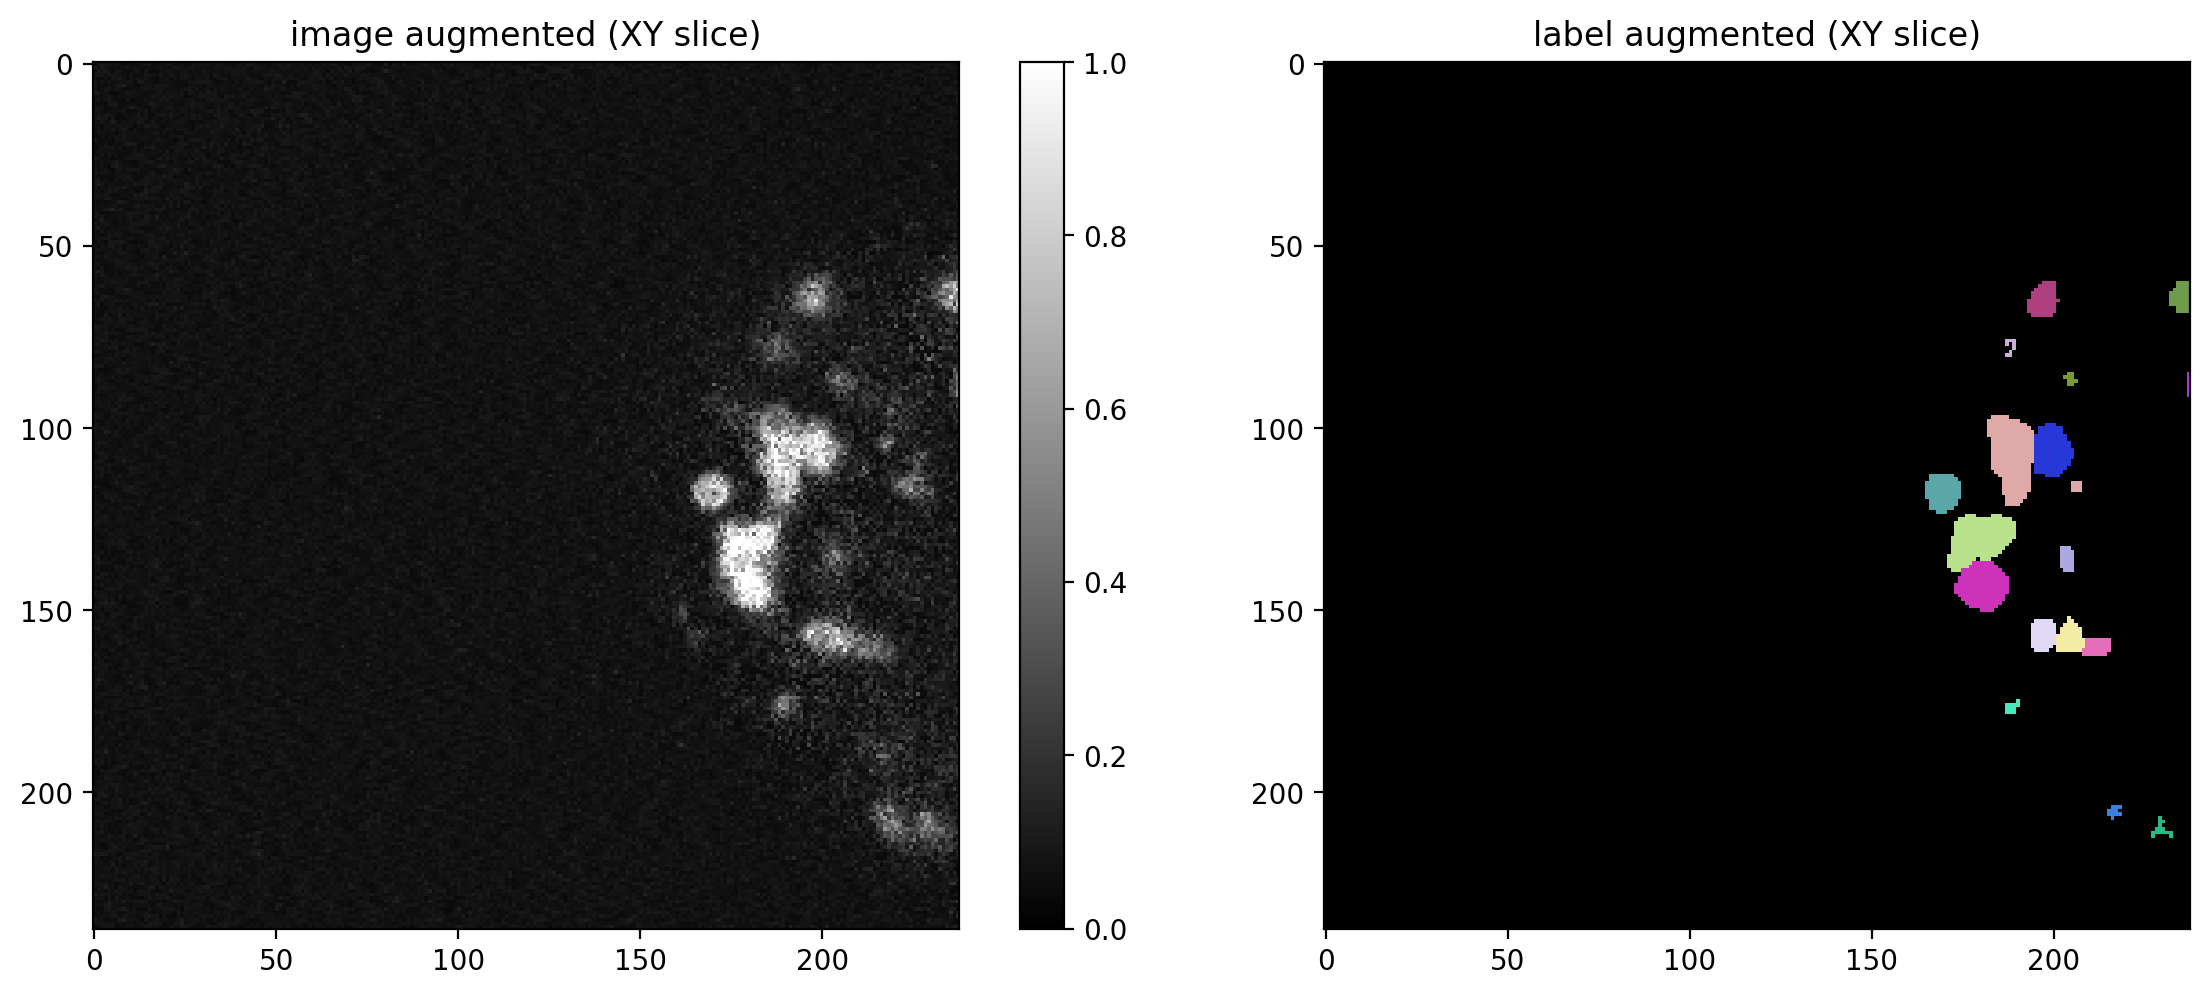

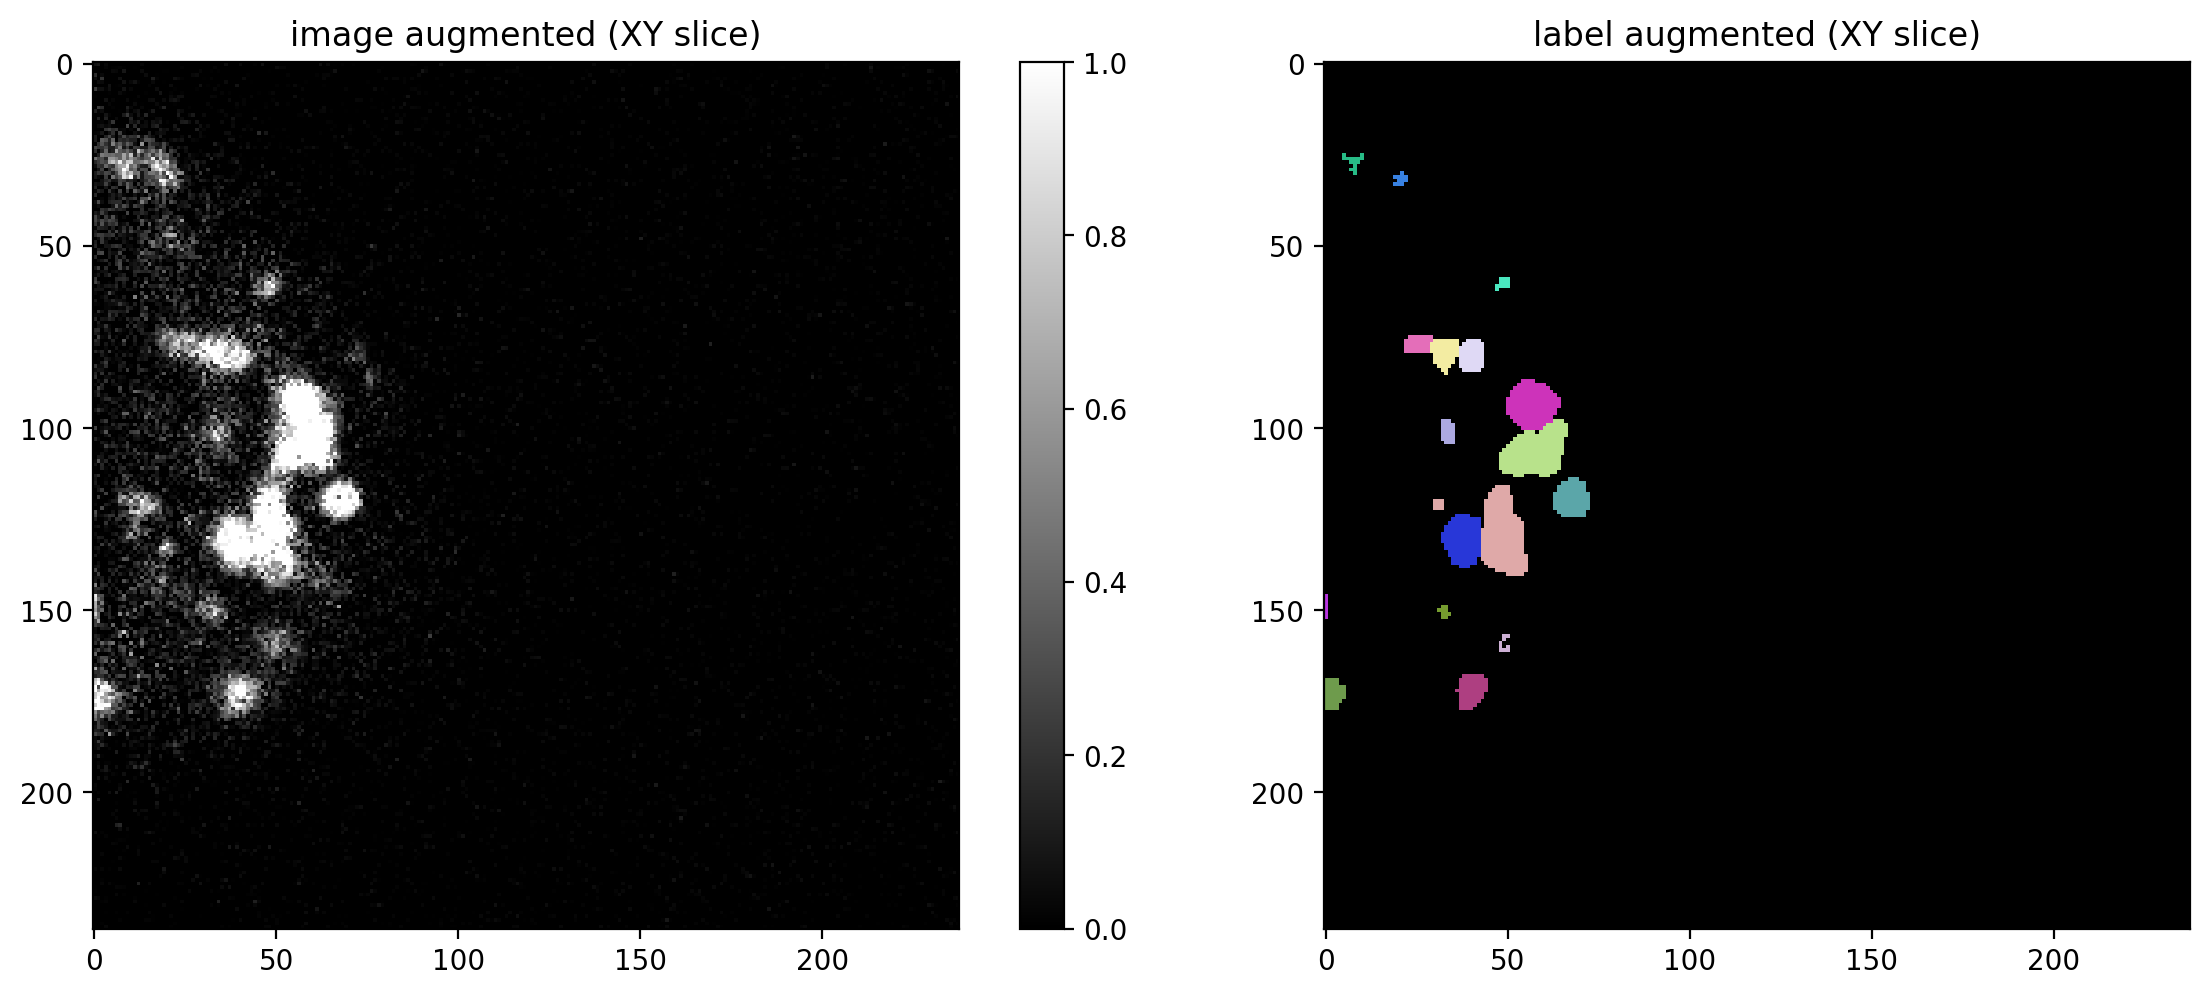

In [12]:
# plot some augmented examples
img, lbl = X_trn[0],Y_trn[0]
plot_img_label(img, lbl)
for _ in range(3):
    img_aug, lbl_aug = augmenter(img,lbl)
    plot_img_label(img_aug, lbl_aug, img_title="image augmented (XY slice)", lbl_title="label augmented (XY slice)")

# Training

We recommend to monitor the progress during training with [TensorBoard](https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard). You can start it in the shell from the current working directory like this:

    $ tensorboard --logdir=.

Then connect to [http://localhost:6006/](http://localhost:6006/) with your browser.


In [13]:
quick_demo = False

if quick_demo:
    print (
        "NOTE: This is only for a quick demonstration!\n"
        "      Please set the variable 'quick_demo = False' for proper (long) training.",
        file=sys.stderr, flush=True
    )
    model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter,
                epochs=2, steps_per_epoch=5)

    print("====> Stopping training and loading previously trained demo model from disk.", file=sys.stderr, flush=True)
    model = StarDist3D.from_pretrained('3D_demo')
else:
    model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter)
None;

Epoch 1/400
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function _gcd_import at 0x7f23543a4b00>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function _gcd_import at 0x7f23543a4b00>. Note that functions defined in certain environments, like the interactive 

2022-09-05 14:49:38.502950: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2022-09-05 14:49:39.675881: W tensorflow/stream_executor/gpu/asm_compiler.cc:81] Running ptxas --version returned 256
2022-09-05 14:49:39.751839: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-09-05 14:49:40.153007: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


200/200 [==============================] - 14s 70ms/step - loss: 0.5965 - prob_loss: 0.1388 - dist_loss: 2.2883 - prob_kld: 0.0941 - dist_relevant_mae: 2.2881 - dist_relevant_mse: 12.1527 - dist_dist_iou_metric: 0.2806 - val_loss: 0.2568 - val_prob_loss: 0.0198 - val_dist_loss: 1.1850 - val_prob_kld: 0.0146 - val_dist_relevant_mae: 1.1848 - val_dist_relevant_mse: 2.6906 - val_dist_dist_iou_metric: 0.3425
Epoch 2/400
200/200 [==============================] - 9s 47ms/step - loss: 0.4338 - prob_loss: 0.1045 - dist_loss: 1.6465 - prob_kld: 0.0613 - dist_relevant_mae: 1.6462 - dist_relevant_mse: 6.0698 - dist_dist_iou_metric: 0.3769 - val_loss: 0.2051 - val_prob_loss: 0.0132 - val_dist_loss: 0.9597 - val_prob_kld: 0.0080 - val_dist_relevant_mae: 0.9594 - val_dist_relevant_mse: 1.9093 - val_dist_dist_iou_metric: 0.4813
Epoch 3/400
200/200 [==============================] - 9s 47ms/step - loss: 0.3920 - prob_loss: 0.0845 - dist_loss: 1.5377 - prob_kld: 0.0463 - dist_relevant_mae: 1.5374 - di

Epoch 20/400
200/200 [==============================] - 9s 47ms/step - loss: 0.3167 - prob_loss: 0.0770 - dist_loss: 1.1984 - prob_kld: 0.0340 - dist_relevant_mae: 1.1981 - dist_relevant_mse: 3.5291 - dist_dist_iou_metric: 0.5322 - val_loss: 0.1676 - val_prob_loss: 0.0139 - val_dist_loss: 0.7687 - val_prob_kld: 0.0087 - val_dist_relevant_mae: 0.7684 - val_dist_relevant_mse: 1.4053 - val_dist_dist_iou_metric: 0.5806
Epoch 21/400
200/200 [==============================] - 9s 47ms/step - loss: 0.2999 - prob_loss: 0.0730 - dist_loss: 1.1344 - prob_kld: 0.0302 - dist_relevant_mae: 1.1342 - dist_relevant_mse: 3.1320 - dist_dist_iou_metric: 0.5416 - val_loss: 0.1745 - val_prob_loss: 0.0181 - val_dist_loss: 0.7817 - val_prob_kld: 0.0129 - val_dist_relevant_mae: 0.7814 - val_dist_relevant_mse: 1.4086 - val_dist_dist_iou_metric: 0.5837
Epoch 22/400
200/200 [==============================] - 9s 47ms/step - loss: 0.2898 - prob_loss: 0.0651 - dist_loss: 1.1236 - prob_kld: 0.0268 - dist_relevant_mae

200/200 [==============================] - 9s 47ms/step - loss: 0.2701 - prob_loss: 0.0645 - dist_loss: 1.0280 - prob_kld: 0.0239 - dist_relevant_mae: 1.0277 - dist_relevant_mse: 2.6926 - dist_dist_iou_metric: 0.5681 - val_loss: 0.1726 - val_prob_loss: 0.0156 - val_dist_loss: 0.7847 - val_prob_kld: 0.0104 - val_dist_relevant_mae: 0.7844 - val_dist_relevant_mse: 1.6788 - val_dist_dist_iou_metric: 0.5981
Epoch 40/400
200/200 [==============================] - 9s 47ms/step - loss: 0.2824 - prob_loss: 0.0693 - dist_loss: 1.0656 - prob_kld: 0.0284 - dist_relevant_mae: 1.0653 - dist_relevant_mse: 2.8175 - dist_dist_iou_metric: 0.5702 - val_loss: 0.1714 - val_prob_loss: 0.0214 - val_dist_loss: 0.7497 - val_prob_kld: 0.0162 - val_dist_relevant_mae: 0.7493 - val_dist_relevant_mse: 1.4168 - val_dist_dist_iou_metric: 0.5924
Epoch 41/400
200/200 [==============================] - 9s 47ms/step - loss: 0.2707 - prob_loss: 0.0606 - dist_loss: 1.0505 - prob_kld: 0.0221 - dist_relevant_mae: 1.0502 - di

Epoch 59/400
200/200 [==============================] - 9s 47ms/step - loss: 0.2713 - prob_loss: 0.0695 - dist_loss: 1.0088 - prob_kld: 0.0259 - dist_relevant_mae: 1.0086 - dist_relevant_mse: 2.5813 - dist_dist_iou_metric: 0.5814 - val_loss: 0.1358 - val_prob_loss: 0.0100 - val_dist_loss: 0.6291 - val_prob_kld: 0.0048 - val_dist_relevant_mae: 0.6288 - val_dist_relevant_mse: 1.1321 - val_dist_dist_iou_metric: 0.6432
Epoch 60/400
200/200 [==============================] - 9s 47ms/step - loss: 0.2528 - prob_loss: 0.0609 - dist_loss: 0.9598 - prob_kld: 0.0215 - dist_relevant_mae: 0.9595 - dist_relevant_mse: 2.3870 - dist_dist_iou_metric: 0.5993 - val_loss: 0.1673 - val_prob_loss: 0.0150 - val_dist_loss: 0.7615 - val_prob_kld: 0.0098 - val_dist_relevant_mae: 0.7612 - val_dist_relevant_mse: 1.6424 - val_dist_dist_iou_metric: 0.6198
Epoch 61/400
200/200 [==============================] - 9s 46ms/step - loss: 0.2558 - prob_loss: 0.0613 - dist_loss: 0.9725 - prob_kld: 0.0226 - dist_relevant_mae

Epoch 79/400
200/200 [==============================] - 9s 47ms/step - loss: 0.2307 - prob_loss: 0.0529 - dist_loss: 0.8889 - prob_kld: 0.0185 - dist_relevant_mae: 0.8887 - dist_relevant_mse: 2.0913 - dist_dist_iou_metric: 0.6044 - val_loss: 0.1349 - val_prob_loss: 0.0109 - val_dist_loss: 0.6201 - val_prob_kld: 0.0057 - val_dist_relevant_mae: 0.6199 - val_dist_relevant_mse: 1.1220 - val_dist_dist_iou_metric: 0.6479
Epoch 80/400
200/200 [==============================] - 9s 47ms/step - loss: 0.2498 - prob_loss: 0.0634 - dist_loss: 0.9319 - prob_kld: 0.0217 - dist_relevant_mae: 0.9317 - dist_relevant_mse: 2.2813 - dist_dist_iou_metric: 0.6071 - val_loss: 0.1381 - val_prob_loss: 0.0122 - val_dist_loss: 0.6294 - val_prob_kld: 0.0070 - val_dist_relevant_mae: 0.6291 - val_dist_relevant_mse: 1.1334 - val_dist_dist_iou_metric: 0.6493
Epoch 81/400
200/200 [==============================] - 9s 47ms/step - loss: 0.2458 - prob_loss: 0.0594 - dist_loss: 0.9321 - prob_kld: 0.0204 - dist_relevant_mae

Epoch 99/400
200/200 [==============================] - 9s 45ms/step - loss: 0.2394 - prob_loss: 0.0615 - dist_loss: 0.8894 - prob_kld: 0.0211 - dist_relevant_mae: 0.8892 - dist_relevant_mse: 2.0878 - dist_dist_iou_metric: 0.6254 - val_loss: 0.1309 - val_prob_loss: 0.0125 - val_dist_loss: 0.5918 - val_prob_kld: 0.0074 - val_dist_relevant_mae: 0.5916 - val_dist_relevant_mse: 1.0654 - val_dist_dist_iou_metric: 0.6693
Epoch 100/400
200/200 [==============================] - 9s 45ms/step - loss: 0.2341 - prob_loss: 0.0565 - dist_loss: 0.8875 - prob_kld: 0.0197 - dist_relevant_mae: 0.8873 - dist_relevant_mse: 2.0462 - dist_dist_iou_metric: 0.6226 - val_loss: 0.1276 - val_prob_loss: 0.0106 - val_dist_loss: 0.5851 - val_prob_kld: 0.0054 - val_dist_relevant_mae: 0.5848 - val_dist_relevant_mse: 0.9967 - val_dist_dist_iou_metric: 0.6631
Epoch 101/400
200/200 [==============================] - 9s 45ms/step - loss: 0.2247 - prob_loss: 0.0522 - dist_loss: 0.8624 - prob_kld: 0.0176 - dist_relevant_m

200/200 [==============================] - 9s 46ms/step - loss: 0.2405 - prob_loss: 0.0632 - dist_loss: 0.8865 - prob_kld: 0.0210 - dist_relevant_mae: 0.8863 - dist_relevant_mse: 2.0940 - dist_dist_iou_metric: 0.6277 - val_loss: 0.1358 - val_prob_loss: 0.0106 - val_dist_loss: 0.6260 - val_prob_kld: 0.0054 - val_dist_relevant_mae: 0.6258 - val_dist_relevant_mse: 1.2472 - val_dist_dist_iou_metric: 0.6560
Epoch 119/400
200/200 [==============================] - 9s 46ms/step - loss: 0.2403 - prob_loss: 0.0602 - dist_loss: 0.9007 - prob_kld: 0.0199 - dist_relevant_mae: 0.9006 - dist_relevant_mse: 2.1332 - dist_dist_iou_metric: 0.6171 - val_loss: 0.1371 - val_prob_loss: 0.0127 - val_dist_loss: 0.6221 - val_prob_kld: 0.0075 - val_dist_relevant_mae: 0.6220 - val_dist_relevant_mse: 1.1997 - val_dist_dist_iou_metric: 0.6598
Epoch 120/400
200/200 [==============================] - 9s 47ms/step - loss: 0.2320 - prob_loss: 0.0562 - dist_loss: 0.8789 - prob_kld: 0.0185 - dist_relevant_mae: 0.8788 - 

Epoch 138/400
200/200 [==============================] - 9s 47ms/step - loss: 0.2192 - prob_loss: 0.0539 - dist_loss: 0.8268 - prob_kld: 0.0176 - dist_relevant_mae: 0.8266 - dist_relevant_mse: 1.8577 - dist_dist_iou_metric: 0.6362 - val_loss: 0.1208 - val_prob_loss: 0.0090 - val_dist_loss: 0.5588 - val_prob_kld: 0.0038 - val_dist_relevant_mae: 0.5586 - val_dist_relevant_mse: 0.9642 - val_dist_dist_iou_metric: 0.6796
Epoch 139/400
200/200 [==============================] - 9s 47ms/step - loss: 0.2403 - prob_loss: 0.0657 - dist_loss: 0.8729 - prob_kld: 0.0215 - dist_relevant_mae: 0.8727 - dist_relevant_mse: 2.0595 - dist_dist_iou_metric: 0.6248 - val_loss: 0.1203 - val_prob_loss: 0.0096 - val_dist_loss: 0.5537 - val_prob_kld: 0.0044 - val_dist_relevant_mae: 0.5535 - val_dist_relevant_mse: 0.9731 - val_dist_dist_iou_metric: 0.6819
Epoch 140/400
200/200 [==============================] - 9s 47ms/step - loss: 0.2403 - prob_loss: 0.0640 - dist_loss: 0.8819 - prob_kld: 0.0225 - dist_relevant_

200/200 [==============================] - 9s 47ms/step - loss: 0.2343 - prob_loss: 0.0626 - dist_loss: 0.8584 - prob_kld: 0.0203 - dist_relevant_mae: 0.8582 - dist_relevant_mse: 1.9947 - dist_dist_iou_metric: 0.6311 - val_loss: 0.1278 - val_prob_loss: 0.0100 - val_dist_loss: 0.5890 - val_prob_kld: 0.0048 - val_dist_relevant_mae: 0.5888 - val_dist_relevant_mse: 1.0478 - val_dist_dist_iou_metric: 0.6670
Epoch 158/400
200/200 [==============================] - 9s 46ms/step - loss: 0.2369 - prob_loss: 0.0629 - dist_loss: 0.8702 - prob_kld: 0.0199 - dist_relevant_mae: 0.8699 - dist_relevant_mse: 2.0122 - dist_dist_iou_metric: 0.6350 - val_loss: 0.1264 - val_prob_loss: 0.0097 - val_dist_loss: 0.5834 - val_prob_kld: 0.0045 - val_dist_relevant_mae: 0.5832 - val_dist_relevant_mse: 1.0760 - val_dist_dist_iou_metric: 0.6763
Epoch 159/400
200/200 [==============================] - 9s 46ms/step - loss: 0.2400 - prob_loss: 0.0657 - dist_loss: 0.8714 - prob_kld: 0.0212 - dist_relevant_mae: 0.8712 - 

Epoch 177/400
200/200 [==============================] - 9s 45ms/step - loss: 0.2291 - prob_loss: 0.0588 - dist_loss: 0.8515 - prob_kld: 0.0184 - dist_relevant_mae: 0.8512 - dist_relevant_mse: 1.9773 - dist_dist_iou_metric: 0.6440 - val_loss: 0.1228 - val_prob_loss: 0.0094 - val_dist_loss: 0.5673 - val_prob_kld: 0.0042 - val_dist_relevant_mae: 0.5671 - val_dist_relevant_mse: 1.0269 - val_dist_dist_iou_metric: 0.6746
Epoch 178/400
200/200 [==============================] - 9s 45ms/step - loss: 0.2361 - prob_loss: 0.0659 - dist_loss: 0.8506 - prob_kld: 0.0207 - dist_relevant_mae: 0.8504 - dist_relevant_mse: 1.9368 - dist_dist_iou_metric: 0.6427 - val_loss: 0.1169 - val_prob_loss: 0.0093 - val_dist_loss: 0.5380 - val_prob_kld: 0.0041 - val_dist_relevant_mae: 0.5378 - val_dist_relevant_mse: 0.8532 - val_dist_dist_iou_metric: 0.6747
Epoch 179/400
200/200 [==============================] - 9s 44ms/step - loss: 0.2287 - prob_loss: 0.0589 - dist_loss: 0.8491 - prob_kld: 0.0194 - dist_relevant_

200/200 [==============================] - 10s 48ms/step - loss: 0.2178 - prob_loss: 0.0576 - dist_loss: 0.8010 - prob_kld: 0.0181 - dist_relevant_mae: 0.8008 - dist_relevant_mse: 1.7423 - dist_dist_iou_metric: 0.6519 - val_loss: 0.1255 - val_prob_loss: 0.0139 - val_dist_loss: 0.5581 - val_prob_kld: 0.0087 - val_dist_relevant_mae: 0.5579 - val_dist_relevant_mse: 0.9504 - val_dist_dist_iou_metric: 0.6696
Epoch 197/400
200/200 [==============================] - 10s 48ms/step - loss: 0.2289 - prob_loss: 0.0620 - dist_loss: 0.8347 - prob_kld: 0.0198 - dist_relevant_mae: 0.8345 - dist_relevant_mse: 1.9026 - dist_dist_iou_metric: 0.6399 - val_loss: 0.1201 - val_prob_loss: 0.0097 - val_dist_loss: 0.5516 - val_prob_kld: 0.0046 - val_dist_relevant_mae: 0.5514 - val_dist_relevant_mse: 1.0040 - val_dist_dist_iou_metric: 0.6864
Epoch 198/400
200/200 [==============================] - 10s 49ms/step - loss: 0.2301 - prob_loss: 0.0626 - dist_loss: 0.8375 - prob_kld: 0.0208 - dist_relevant_mae: 0.8373

200/200 [==============================] - 9s 45ms/step - loss: 0.2207 - prob_loss: 0.0564 - dist_loss: 0.8216 - prob_kld: 0.0168 - dist_relevant_mae: 0.8214 - dist_relevant_mse: 1.8465 - dist_dist_iou_metric: 0.6530 - val_loss: 0.1192 - val_prob_loss: 0.0099 - val_dist_loss: 0.5465 - val_prob_kld: 0.0048 - val_dist_relevant_mae: 0.5462 - val_dist_relevant_mse: 0.9245 - val_dist_dist_iou_metric: 0.6811
Epoch 216/400
200/200 [==============================] - 9s 45ms/step - loss: 0.2229 - prob_loss: 0.0604 - dist_loss: 0.8126 - prob_kld: 0.0197 - dist_relevant_mae: 0.8123 - dist_relevant_mse: 1.8144 - dist_dist_iou_metric: 0.6423 - val_loss: 0.1149 - val_prob_loss: 0.0093 - val_dist_loss: 0.5282 - val_prob_kld: 0.0041 - val_dist_relevant_mae: 0.5280 - val_dist_relevant_mse: 0.8543 - val_dist_dist_iou_metric: 0.6767
Epoch 217/400
200/200 [==============================] - 9s 45ms/step - loss: 0.2309 - prob_loss: 0.0655 - dist_loss: 0.8273 - prob_kld: 0.0201 - dist_relevant_mae: 0.8271 - 

Epoch 235/400
200/200 [==============================] - 9s 45ms/step - loss: 0.2100 - prob_loss: 0.0528 - dist_loss: 0.7858 - prob_kld: 0.0168 - dist_relevant_mae: 0.7856 - dist_relevant_mse: 1.7080 - dist_dist_iou_metric: 0.6518 - val_loss: 0.1154 - val_prob_loss: 0.0096 - val_dist_loss: 0.5290 - val_prob_kld: 0.0044 - val_dist_relevant_mae: 0.5288 - val_dist_relevant_mse: 0.9048 - val_dist_dist_iou_metric: 0.6859
Epoch 236/400
200/200 [==============================] - 9s 45ms/step - loss: 0.2186 - prob_loss: 0.0578 - dist_loss: 0.8040 - prob_kld: 0.0176 - dist_relevant_mae: 0.8037 - dist_relevant_mse: 1.7990 - dist_dist_iou_metric: 0.6480 - val_loss: 0.1181 - val_prob_loss: 0.0091 - val_dist_loss: 0.5449 - val_prob_kld: 0.0039 - val_dist_relevant_mae: 0.5447 - val_dist_relevant_mse: 0.9781 - val_dist_dist_iou_metric: 0.6795
Epoch 237/400
200/200 [==============================] - 9s 45ms/step - loss: 0.2263 - prob_loss: 0.0614 - dist_loss: 0.8247 - prob_kld: 0.0186 - dist_relevant_

200/200 [==============================] - 10s 49ms/step - loss: 0.2144 - prob_loss: 0.0560 - dist_loss: 0.7919 - prob_kld: 0.0170 - dist_relevant_mae: 0.7917 - dist_relevant_mse: 1.7487 - dist_dist_iou_metric: 0.6553 - val_loss: 0.1213 - val_prob_loss: 0.0110 - val_dist_loss: 0.5516 - val_prob_kld: 0.0058 - val_dist_relevant_mae: 0.5514 - val_dist_relevant_mse: 1.0445 - val_dist_dist_iou_metric: 0.6877
Epoch 255/400
200/200 [==============================] - 10s 49ms/step - loss: 0.2267 - prob_loss: 0.0644 - dist_loss: 0.8113 - prob_kld: 0.0204 - dist_relevant_mae: 0.8111 - dist_relevant_mse: 1.8262 - dist_dist_iou_metric: 0.6490 - val_loss: 0.1198 - val_prob_loss: 0.0122 - val_dist_loss: 0.5380 - val_prob_kld: 0.0070 - val_dist_relevant_mae: 0.5378 - val_dist_relevant_mse: 0.8961 - val_dist_dist_iou_metric: 0.6875
Epoch 256/400
200/200 [==============================] - 10s 49ms/step - loss: 0.2315 - prob_loss: 0.0642 - dist_loss: 0.8363 - prob_kld: 0.0196 - dist_relevant_mae: 0.8361

200/200 [==============================] - 10s 48ms/step - loss: 0.2075 - prob_loss: 0.0532 - dist_loss: 0.7715 - prob_kld: 0.0169 - dist_relevant_mae: 0.7713 - dist_relevant_mse: 1.6874 - dist_dist_iou_metric: 0.6621 - val_loss: 0.1112 - val_prob_loss: 0.0095 - val_dist_loss: 0.5085 - val_prob_kld: 0.0043 - val_dist_relevant_mae: 0.5083 - val_dist_relevant_mse: 0.8234 - val_dist_dist_iou_metric: 0.6758
Epoch 274/400
200/200 [==============================] - 10s 48ms/step - loss: 0.2174 - prob_loss: 0.0597 - dist_loss: 0.7882 - prob_kld: 0.0179 - dist_relevant_mae: 0.7880 - dist_relevant_mse: 1.7044 - dist_dist_iou_metric: 0.6590 - val_loss: 0.1178 - val_prob_loss: 0.0095 - val_dist_loss: 0.5413 - val_prob_kld: 0.0043 - val_dist_relevant_mae: 0.5410 - val_dist_relevant_mse: 0.8925 - val_dist_dist_iou_metric: 0.7046
Epoch 275/400
200/200 [==============================] - 10s 48ms/step - loss: 0.2096 - prob_loss: 0.0556 - dist_loss: 0.7699 - prob_kld: 0.0172 - dist_relevant_mae: 0.7697

200/200 [==============================] - 10s 48ms/step - loss: 0.2128 - prob_loss: 0.0538 - dist_loss: 0.7949 - prob_kld: 0.0159 - dist_relevant_mae: 0.7947 - dist_relevant_mse: 1.7681 - dist_dist_iou_metric: 0.6583 - val_loss: 0.1165 - val_prob_loss: 0.0095 - val_dist_loss: 0.5348 - val_prob_kld: 0.0043 - val_dist_relevant_mae: 0.5346 - val_dist_relevant_mse: 0.9703 - val_dist_dist_iou_metric: 0.6894
Epoch 293/400
200/200 [==============================] - 10s 48ms/step - loss: 0.2139 - prob_loss: 0.0579 - dist_loss: 0.7799 - prob_kld: 0.0174 - dist_relevant_mae: 0.7796 - dist_relevant_mse: 1.6958 - dist_dist_iou_metric: 0.6619 - val_loss: 0.1133 - val_prob_loss: 0.0092 - val_dist_loss: 0.5205 - val_prob_kld: 0.0041 - val_dist_relevant_mae: 0.5203 - val_dist_relevant_mse: 0.9041 - val_dist_dist_iou_metric: 0.6930
Epoch 294/400
200/200 [==============================] - 10s 48ms/step - loss: 0.1992 - prob_loss: 0.0504 - dist_loss: 0.7438 - prob_kld: 0.0157 - dist_relevant_mae: 0.7436

200/200 [==============================] - 10s 48ms/step - loss: 0.2124 - prob_loss: 0.0563 - dist_loss: 0.7803 - prob_kld: 0.0170 - dist_relevant_mae: 0.7801 - dist_relevant_mse: 1.7192 - dist_dist_iou_metric: 0.6535 - val_loss: 0.1134 - val_prob_loss: 0.0102 - val_dist_loss: 0.5161 - val_prob_kld: 0.0050 - val_dist_relevant_mae: 0.5159 - val_dist_relevant_mse: 0.8887 - val_dist_dist_iou_metric: 0.6943
Epoch 312/400
200/200 [==============================] - 10s 48ms/step - loss: 0.2137 - prob_loss: 0.0598 - dist_loss: 0.7694 - prob_kld: 0.0179 - dist_relevant_mae: 0.7691 - dist_relevant_mse: 1.6922 - dist_dist_iou_metric: 0.6486 - val_loss: 0.1302 - val_prob_loss: 0.0102 - val_dist_loss: 0.6000 - val_prob_kld: 0.0050 - val_dist_relevant_mae: 0.5998 - val_dist_relevant_mse: 1.2438 - val_dist_dist_iou_metric: 0.6711
Epoch 313/400
200/200 [==============================] - 9s 47ms/step - loss: 0.2175 - prob_loss: 0.0592 - dist_loss: 0.7916 - prob_kld: 0.0175 - dist_relevant_mae: 0.7914 

200/200 [==============================] - 9s 46ms/step - loss: 0.2081 - prob_loss: 0.0557 - dist_loss: 0.7620 - prob_kld: 0.0167 - dist_relevant_mae: 0.7618 - dist_relevant_mse: 1.6371 - dist_dist_iou_metric: 0.6627 - val_loss: 0.1085 - val_prob_loss: 0.0097 - val_dist_loss: 0.4940 - val_prob_kld: 0.0045 - val_dist_relevant_mae: 0.4938 - val_dist_relevant_mse: 0.7856 - val_dist_dist_iou_metric: 0.6867
Epoch 331/400
200/200 [==============================] - 9s 46ms/step - loss: 0.2064 - prob_loss: 0.0554 - dist_loss: 0.7554 - prob_kld: 0.0162 - dist_relevant_mae: 0.7551 - dist_relevant_mse: 1.6083 - dist_dist_iou_metric: 0.6645 - val_loss: 0.1249 - val_prob_loss: 0.0096 - val_dist_loss: 0.5762 - val_prob_kld: 0.0044 - val_dist_relevant_mae: 0.5760 - val_dist_relevant_mse: 0.9579 - val_dist_dist_iou_metric: 0.6419
Epoch 332/400
200/200 [==============================] - 9s 46ms/step - loss: 0.2056 - prob_loss: 0.0530 - dist_loss: 0.7631 - prob_kld: 0.0156 - dist_relevant_mae: 0.7629 - 

Epoch 349/400
200/200 [==============================] - 9s 46ms/step - loss: 0.2118 - prob_loss: 0.0602 - dist_loss: 0.7577 - prob_kld: 0.0174 - dist_relevant_mae: 0.7575 - dist_relevant_mse: 1.6452 - dist_dist_iou_metric: 0.6670 - val_loss: 0.1101 - val_prob_loss: 0.0089 - val_dist_loss: 0.5061 - val_prob_kld: 0.0037 - val_dist_relevant_mae: 0.5059 - val_dist_relevant_mse: 0.8608 - val_dist_dist_iou_metric: 0.6872
Epoch 350/400
200/200 [==============================] - 9s 46ms/step - loss: 0.2029 - prob_loss: 0.0540 - dist_loss: 0.7449 - prob_kld: 0.0155 - dist_relevant_mae: 0.7447 - dist_relevant_mse: 1.6216 - dist_dist_iou_metric: 0.6754 - val_loss: 0.1084 - val_prob_loss: 0.0089 - val_dist_loss: 0.4975 - val_prob_kld: 0.0038 - val_dist_relevant_mae: 0.4973 - val_dist_relevant_mse: 0.8027 - val_dist_dist_iou_metric: 0.6881
Epoch 351/400
200/200 [==============================] - 9s 47ms/step - loss: 0.2024 - prob_loss: 0.0546 - dist_loss: 0.7388 - prob_kld: 0.0157 - dist_relevant_

200/200 [==============================] - 9s 44ms/step - loss: 0.1981 - prob_loss: 0.0520 - dist_loss: 0.7305 - prob_kld: 0.0151 - dist_relevant_mae: 0.7303 - dist_relevant_mse: 1.5381 - dist_dist_iou_metric: 0.6638 - val_loss: 0.1115 - val_prob_loss: 0.0095 - val_dist_loss: 0.5097 - val_prob_kld: 0.0043 - val_dist_relevant_mae: 0.5095 - val_dist_relevant_mse: 0.8925 - val_dist_dist_iou_metric: 0.6912
Epoch 369/400
200/200 [==============================] - 9s 45ms/step - loss: 0.2122 - prob_loss: 0.0611 - dist_loss: 0.7553 - prob_kld: 0.0177 - dist_relevant_mae: 0.7551 - dist_relevant_mse: 1.6367 - dist_dist_iou_metric: 0.6714 - val_loss: 0.1093 - val_prob_loss: 0.0092 - val_dist_loss: 0.5004 - val_prob_kld: 0.0040 - val_dist_relevant_mae: 0.5003 - val_dist_relevant_mse: 0.8509 - val_dist_dist_iou_metric: 0.6940
Epoch 370/400
200/200 [==============================] - 9s 45ms/step - loss: 0.2072 - prob_loss: 0.0579 - dist_loss: 0.7466 - prob_kld: 0.0161 - dist_relevant_mae: 0.7464 - 

Epoch 388/400
200/200 [==============================] - 9s 44ms/step - loss: 0.2015 - prob_loss: 0.0558 - dist_loss: 0.7281 - prob_kld: 0.0155 - dist_relevant_mae: 0.7279 - dist_relevant_mse: 1.5354 - dist_dist_iou_metric: 0.6801 - val_loss: 0.1092 - val_prob_loss: 0.0096 - val_dist_loss: 0.4980 - val_prob_kld: 0.0044 - val_dist_relevant_mae: 0.4978 - val_dist_relevant_mse: 0.8431 - val_dist_dist_iou_metric: 0.6928
Epoch 389/400
200/200 [==============================] - 9s 44ms/step - loss: 0.2070 - prob_loss: 0.0583 - dist_loss: 0.7437 - prob_kld: 0.0166 - dist_relevant_mae: 0.7435 - dist_relevant_mse: 1.5794 - dist_dist_iou_metric: 0.6727 - val_loss: 0.1178 - val_prob_loss: 0.0100 - val_dist_loss: 0.5390 - val_prob_kld: 0.0048 - val_dist_relevant_mae: 0.5388 - val_dist_relevant_mse: 1.0200 - val_dist_dist_iou_metric: 0.6777
Epoch 390/400
200/200 [==============================] - 9s 45ms/step - loss: 0.2122 - prob_loss: 0.0616 - dist_loss: 0.7530 - prob_kld: 0.0173 - dist_relevant_

# Threshold optimization

While the default values for the probability and non-maximum suppression thresholds already yield good results in many cases, we still recommend to adapt the thresholds to your data. The optimized threshold values are saved to disk and will be automatically loaded with the model.

In [14]:
if quick_demo:
    # only use a single validation image for demo
    model.optimize_thresholds(X_val[:1], Y_val[:1])
else:
    model.optimize_thresholds(X_val, Y_val)

NMS threshold = 0.5:  75%|██████████████████████████████████████████              | 15/20 [01:28<00:29,  5.89s/it, 0.661 -> 0.220]


Using optimized values: prob_thresh=0.666656, nms_thresh=0.3.
Saving to 'thresholds.json'.


# Evaluation and Detection Performance

Besides the losses and metrics during training, we can also quantitatively evaluate the actual detection/segmentation performance on the validation data by considering objects in the ground truth to be correctly matched if there are predicted objects with overlap (here [intersection over union (IoU)](https://en.wikipedia.org/wiki/Jaccard_index)) beyond a chosen IoU threshold $\tau$.

The corresponding matching statistics (average overlap, accuracy, recall, precision, etc.) are typically of greater practical relevance than the losses/metrics computed during training (but harder to formulate as a loss function). 
The value of $\tau$ can be between 0 (even slightly overlapping objects count as correctly predicted) and 1 (only pixel-perfectly overlapping objects count) and which $\tau$ to use depends on the needed segmentation precision/application.

Please see `help(matching)` for definitions of the abbreviations used in the evaluation below and see the Wikipedia page on [Sensitivity and specificity](https://en.wikipedia.org/wiki/Sensitivity_and_specificity) for further details.

In [ ]:
# help(matching)

First predict the labels for all validation images:

In [15]:
Y_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X_val)]

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:12<00:00,  6.22s/it]


Plot a GT/prediction example  

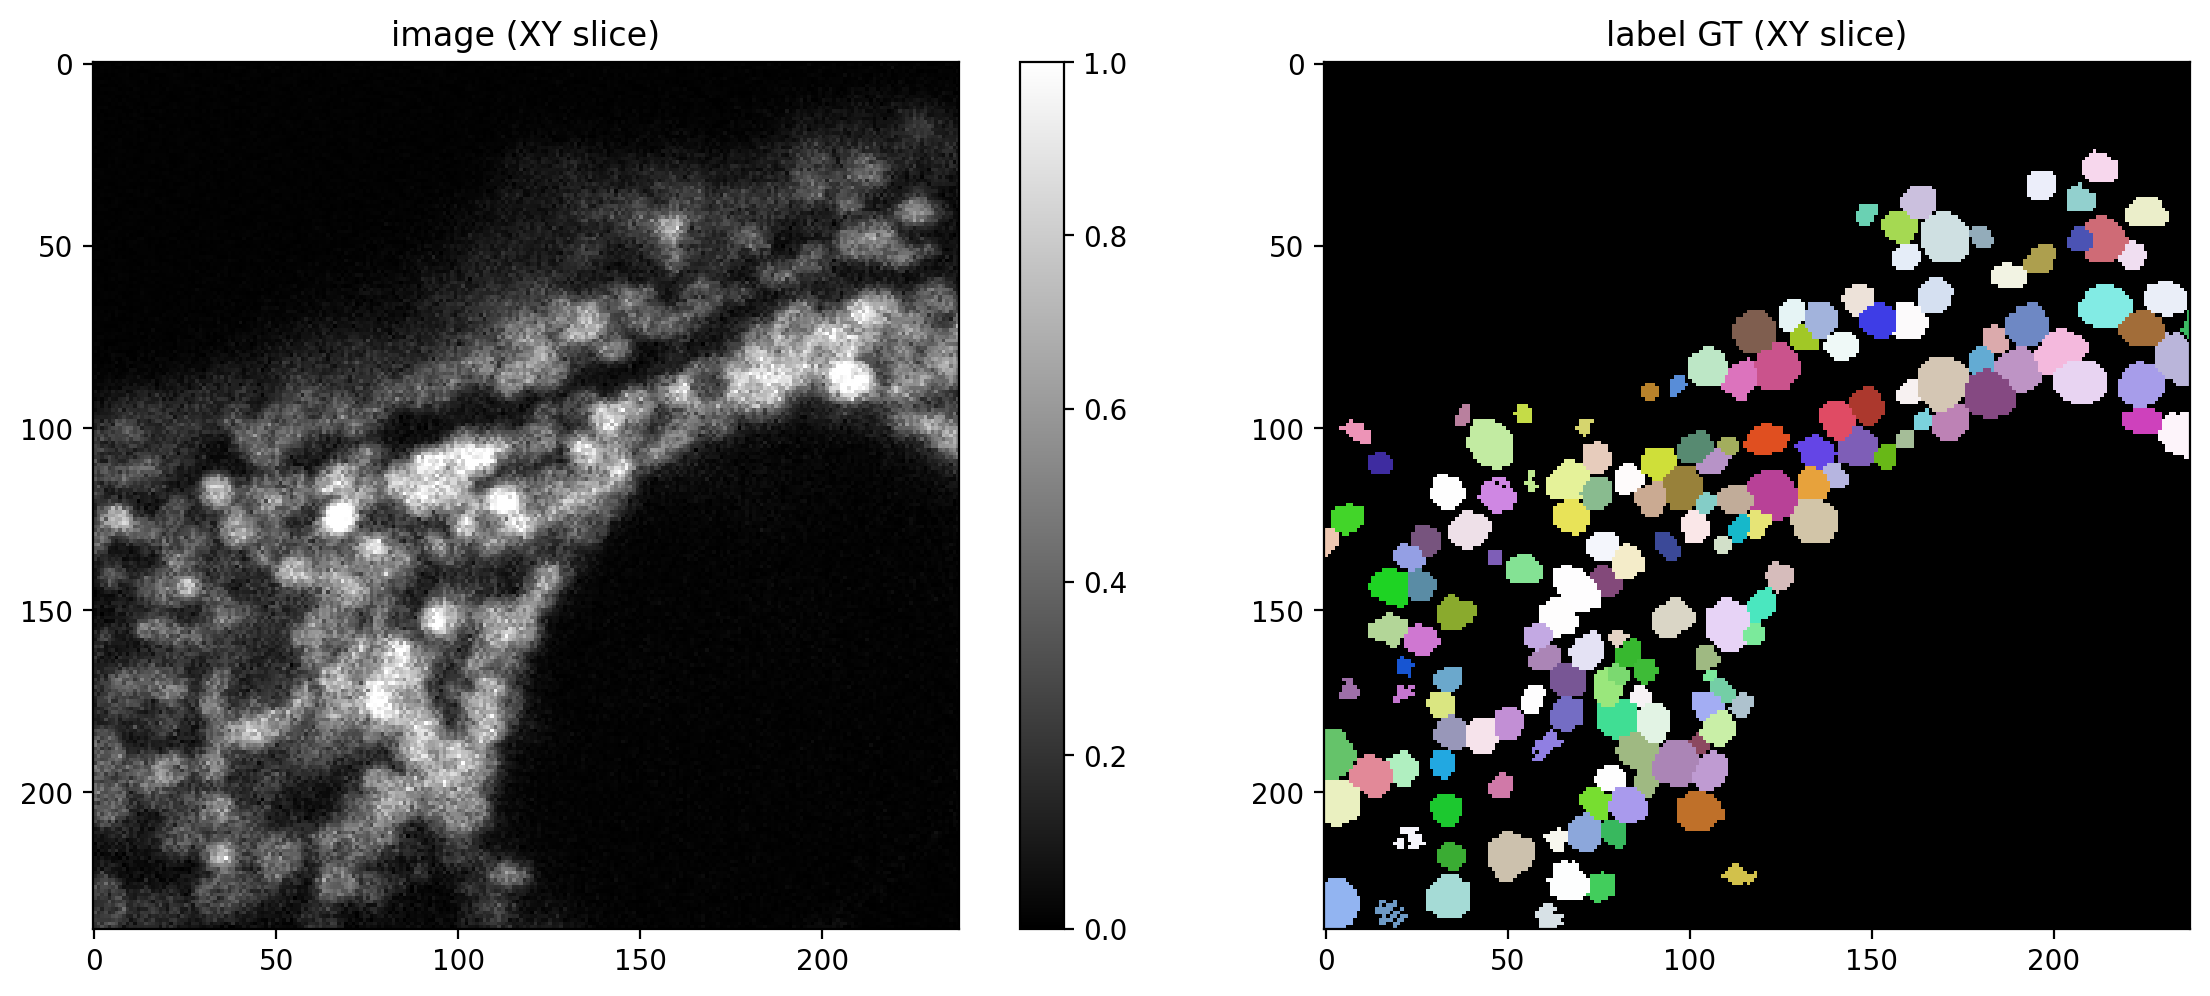

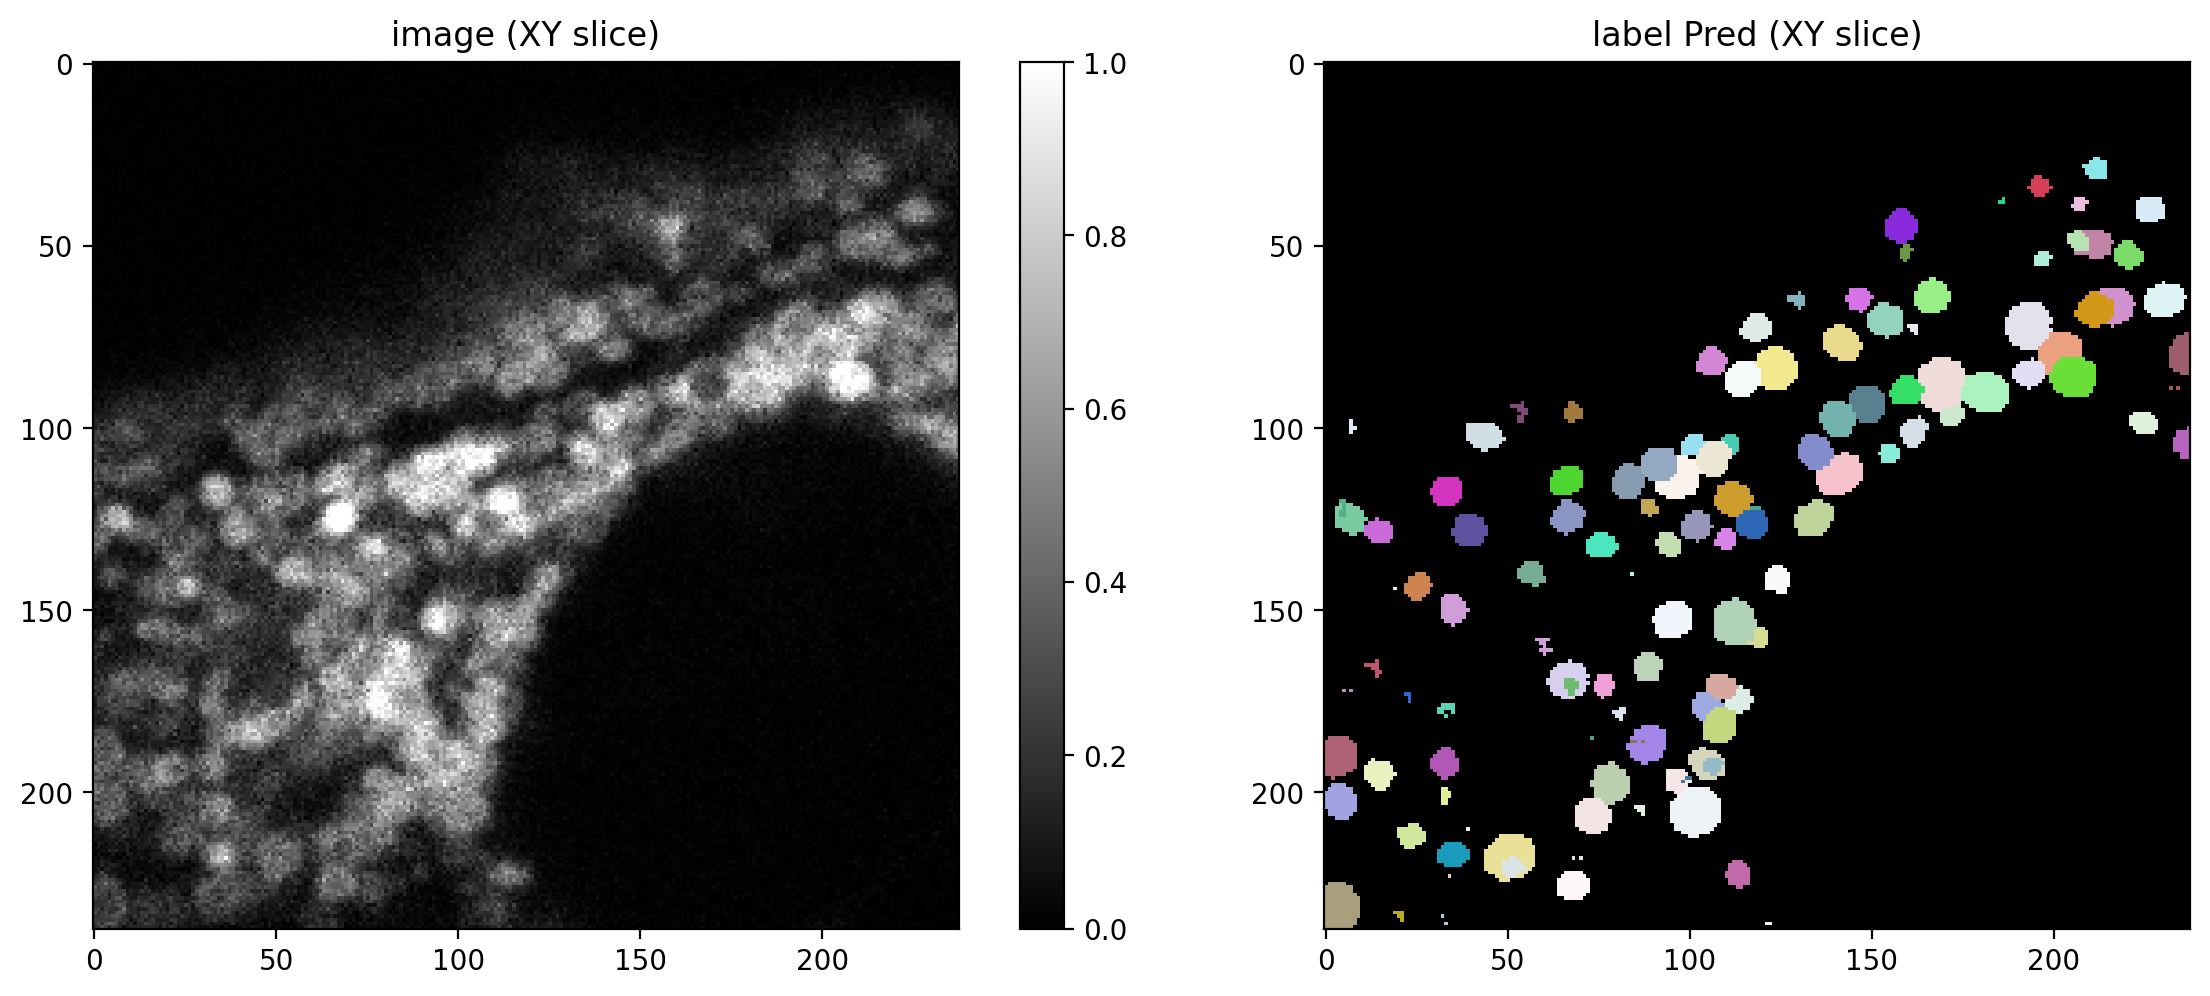

In [45]:
plot_img_label(X_val[1],Y_val[1], lbl_title="label GT (XY slice)")
plot_img_label(X_val[1],Y_val_pred[1], lbl_title="label Pred (XY slice)")

In [20]:
Y_val_pred[0].shape

(38, 238, 238)

In [31]:
import os
import tifffile

In [34]:
?tifffile.imwrite

In [40]:
save_dir = '/mnt/shared/potatoshapes/shannonsdatat/N2Stardist_val_pred'
# pred_list = []
# for idx,img in enumerate(Y_val_pred):
#     name_construct = os.path.basename(file_names[idx])[:-4].replace(' ', '-')
#     name = f'{name_construct}_prediction.tiff'
#     print(name_construct)
#     break
#     tiff_to_write = np.moveaxis(pred, [0], [2])
tifffile.imwrite('/mnt/shared/potatoshapes/shannonsdata/N2Stardist_val_pred/1_raw.tif', data=X_val[1])

Choose several IoU thresholds $\tau$ that might be of interest and for each compute matching statistics for the validation data.

In [41]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y_val, Y_val_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  8.33it/s]


Example: Print all available matching statistics for $\tau=0.7$

In [42]:
stats[taus.index(0.7)]

DatasetMatching(criterion='iou', thresh=0.7, fp=424, tp=24, fn=579, precision=0.05357142857142857, recall=0.03980099502487562, accuracy=0.023369036027263874, f1=0.04567078972407231, n_true=603, n_pred=448, mean_true_score=0.02989533331066024, mean_matched_score=0.7511202494303385, panoptic_quality=0.03430425496922574, by_image=False)

Plot the matching statistics and the number of true/false positives/negatives as a function of the IoU threshold $\tau$. 

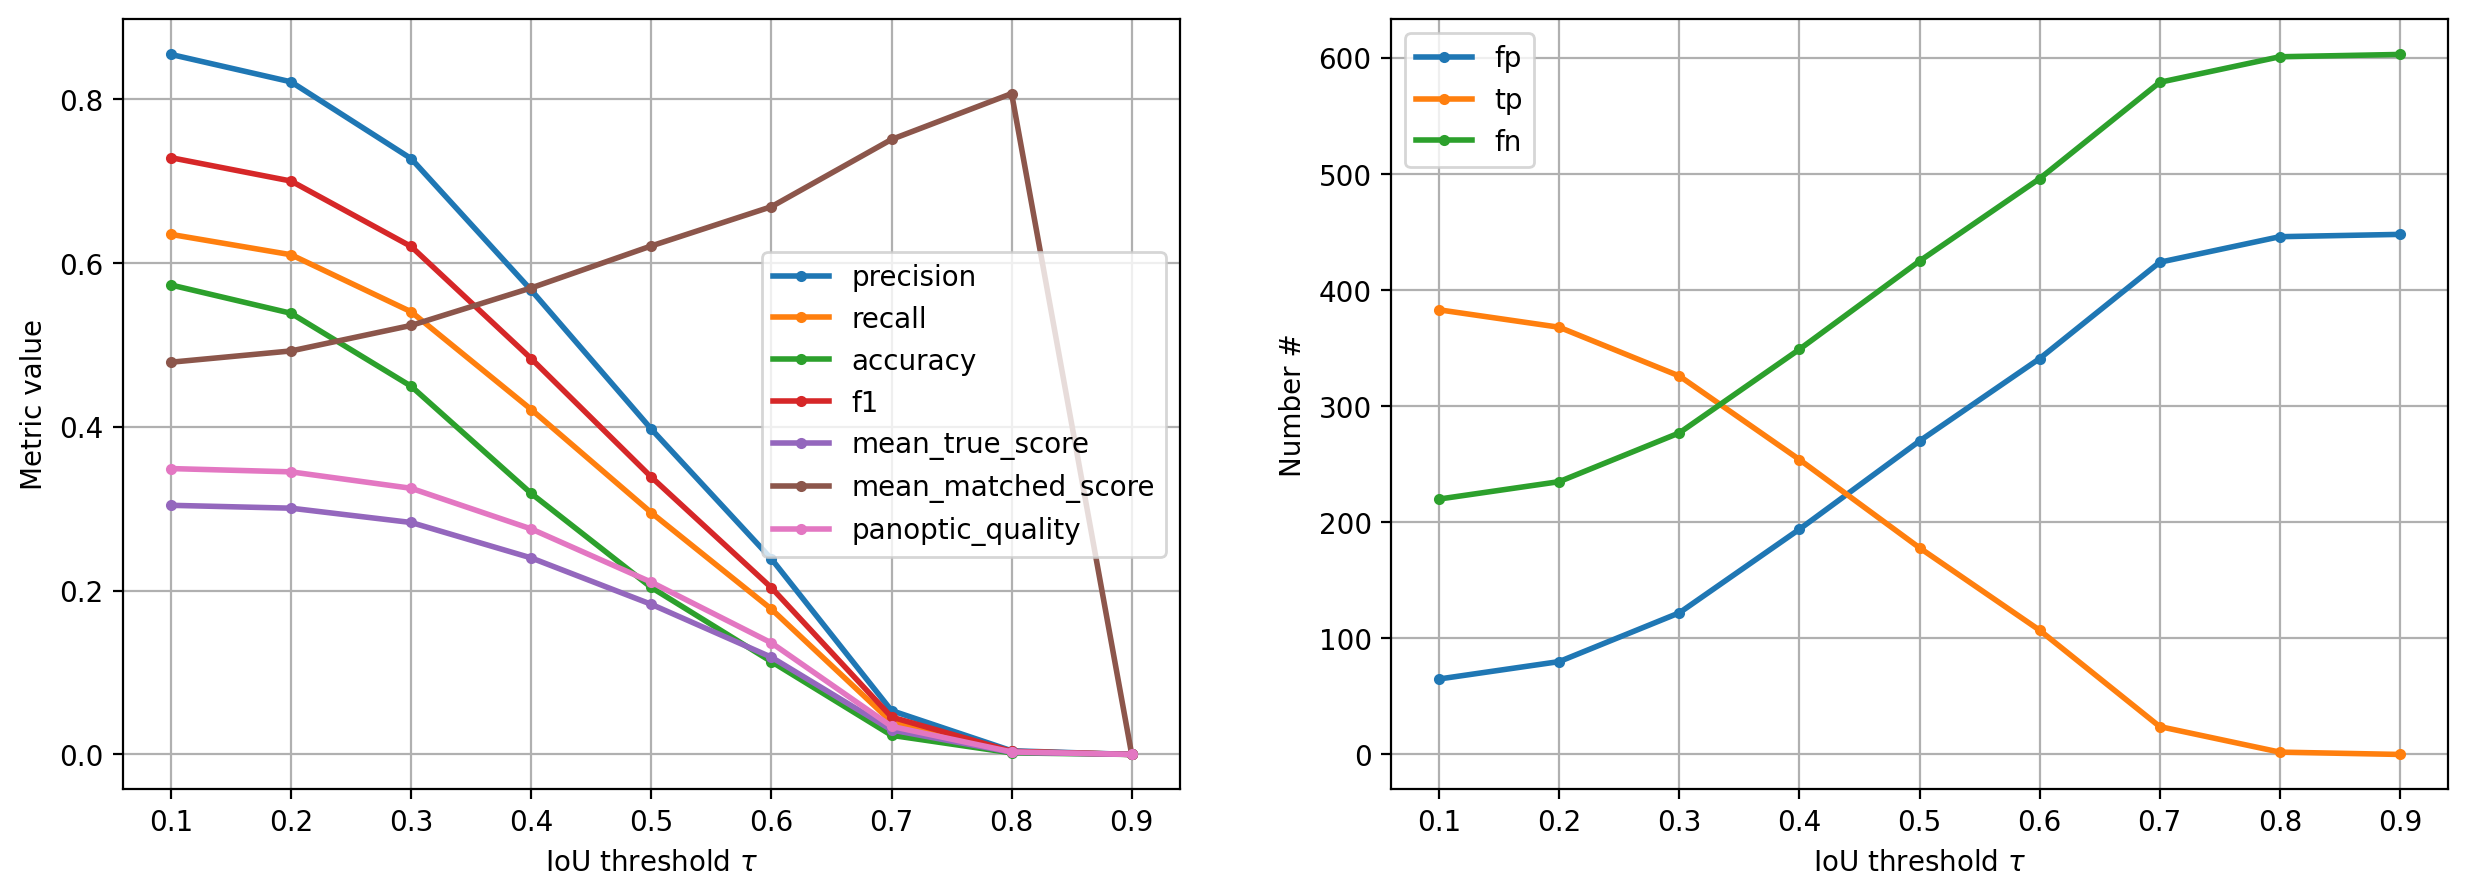

In [43]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();